In [ ]:
# Embedding

## 1. Embeddings and similarity scores

This notebook is based on <a href='https://www.kaggle.com/code/markishere/day-2-embeddings-and-similarity-scores'>Day 2</a> material of Google's Generative AI course (Copyright 2024 Google LLC.), and <a href = '(https://kaggle.com/whitepaper-embeddings-and-vector-stores'>Google's whitepaper on Embedding and Vector Stores/Databases</a> by Anant Nawalgaria and Xiaoqu Ren

### Set up

In [1]:
%pip install -U -q "google-generativeai>=0.8.3"

Note: you may need to restart the kernel to use updated packages.


In [3]:
import google.generativeai as genai
from env import *

%load_ext autoreload
%autoreload 2

In [5]:
GOOGLE_API_KEY = GOOGLE_API_KEY
genai.configure(api_key=GOOGLE_API_KEY)

### Explore available models

Identifying models that support [`embedContent`](https://ai.google.dev/api/embeddings#method:-models.embedcontent), where a text embedding vector is generated from the input.

In [6]:
for model in genai.list_models():
  if 'embedContent' in model.supported_generation_methods:
    print(model.name)

models/embedding-001
models/text-embedding-004


Of the two models listed above, Text Embedding 004 is the newer verion of the Embedding model. (Source : [the models page](https://ai.google.dev/gemini-api/docs/models/gemini#text-embedding))

## Calculate similarity scores

The example below embeds some variations on the pangram, `The quick brown fox jumps over the lazy dog`, including spelling mistakes and shortenings of the phrase. Another pangram and a somewhat unrelated phrase have been included for comparison.

In this task, you are going to use the embeddings to calculate similarity scores, so the `task_type` for these embeddings is `semantic_similarity`. Check out the [API reference](https://ai.google.dev/api/embeddings#v1beta.TaskType) for the full list of tasks.

In [ ]:
from google.api_core import retry
retry_policy = {
    "retry": retry.Retry(predicate=retry.if_transient_error, initial=10, multiplier=1.5, timeout=300)
}

In [9]:
texts = [
    'The quick brown fox jumps over the lazy dog.',
    'The quick rbown fox jumps over the lazy dog.',
    'teh fast fox jumps over the slow woofer.',
    'a quick brown fox jmps over lazy dog.',
    'brown fox jumping over dog',
    'fox > dog',
    # Alternative pangram for comparison:
    'The five boxing wizards jump quickly.',
    # Unrelated text, also for comparison:
    'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus et hendrerit massa. Sed pulvinar, nisi a lobortis sagittis, neque risus gravida dolor, in porta dui odio vel purus.',
]


response = genai.embed_content(model='models/text-embedding-004',
                               content=texts,
                               task_type='semantic_similarity')
response

{'embedding': [[-0.0922682,
   0.012113783,
   -0.0063794684,
   0.0369048,
   0.02203019,
   0.048805293,
   0.0133289965,
   0.021541007,
   0.02705553,
   -0.0043925485,
   -0.011962657,
   0.069833845,
   0.010891116,
   0.06149802,
   0.049922608,
   0.022119658,
   0.0178632,
   0.050096616,
   0.0029887455,
   -0.008278692,
   0.005999019,
   -0.0040636063,
   0.015202278,
   -0.021813663,
   -0.02274539,
   -0.032121718,
   -0.00033075613,
   -0.022031343,
   0.028694874,
   -0.04976425,
   0.025347114,
   0.07245508,
   0.003248612,
   -0.002201165,
   0.059787363,
   -0.0057624904,
   -0.02634191,
   -0.003782781,
   0.048398733,
   0.0066004205,
   -0.05704449,
   -0.022870814,
   -0.058460187,
   0.013212032,
   0.01834201,
   -0.076267265,
   -0.02015255,
   0.014425502,
   0.0024263572,
   -0.011807308,
   0.056245767,
   -0.0031448188,
   0.0013501083,
   -0.009426735,
   -0.020425193,
   0.0015862642,
   0.0039356016,
   0.0071027516,
   -0.032657158,
   -0.0345763,
   

Define a short helper function that will make it easier to display longer embedding texts in our visualisation.

In [10]:
def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

truncated_texts = [truncate(t) for t in texts]
truncated_texts

['The quick brown fox jumps over the lazy dog.',
 'The quick rbown fox jumps over the lazy dog.',
 'teh fast fox jumps over the slow woofer.',
 'a quick brown fox jmps over lazy dog.',
 'brown fox jumping over dog',
 'fox > dog',
 'The five boxing wizards jump quickly.',
 'Lorem ipsum dolor sit amet, consectetur adipisc...']

The inner product (or normalized cosine similarity) is a common way to compute vector similarity. It is obtained by calculating the dot product of two normalized vectors. 

Self-multiplication across all embeddings of a vector matrix `df` can be performed by `df @ df.T`

The similarity scores obtained from the normalized embeddings range from 0.0 (completely dissimilar) to 1.0 (completely similar).

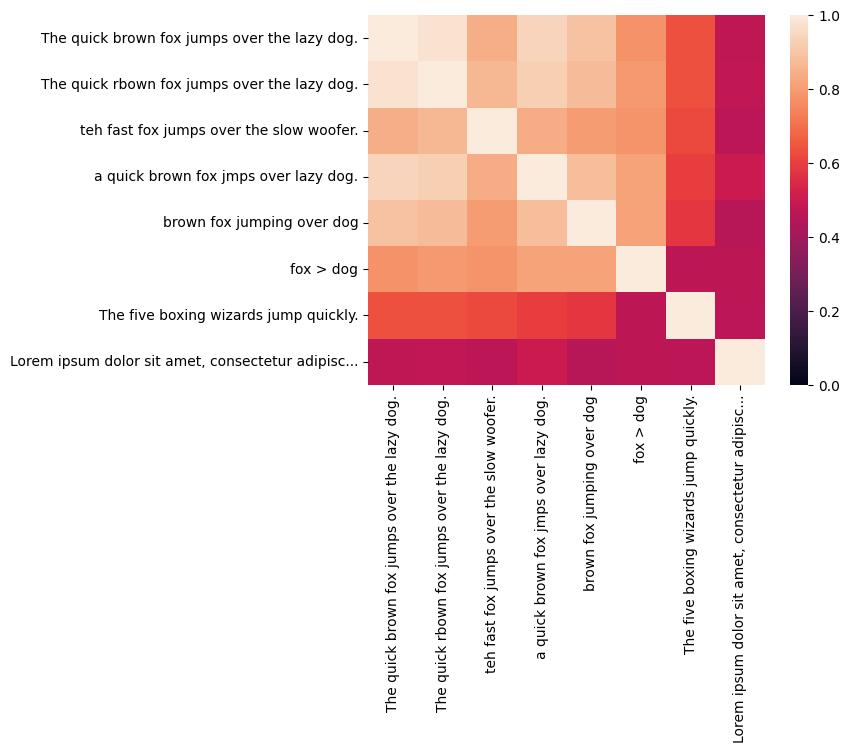

In [ ]:
import pandas as pd
import seaborn as sns


# Set up the embeddings in a dataframe.
df = pd.DataFrame(response['embedding'], index=truncated_texts)
# Perform the similarity calculation
sim = df @ df.T
# Display similarity from dark (0.0) to light (1.0)
sns.heatmap(sim, vmin=0, vmax=1);

The scores for a particular item can be also searched in the dataframe. Below example displays similarity score of the phrase "The quick brown fox jumps over the lazy dog." compared to other text items. 

In [14]:
sim['The quick brown fox jumps over the lazy dog.'].sort_values(ascending=False)

The quick brown fox jumps over the lazy dog.          0.999999
The quick rbown fox jumps over the lazy dog.          0.975623
a quick brown fox jmps over lazy dog.                 0.939730
brown fox jumping over dog                            0.894507
teh fast fox jumps over the slow woofer.              0.842152
fox > dog                                             0.776455
The five boxing wizards jump quickly.                 0.635346
Lorem ipsum dolor sit amet, consectetur adipisc...    0.472174
Name: The quick brown fox jumps over the lazy dog., dtype: float64

Try exploring the embeddings of your own datasets, or explore those available in [Kaggle datasets](https://www.kaggle.com/datasets).

## Further reading

* Explore [search re-ranking using embeddings](https://github.com/google-gemini/cookbook/blob/main/examples/Search_reranking_using_embeddings.ipynb) with the Wikipedia API
* Perform [anomaly detection using embeddings](https://github.com/google-gemini/cookbook/blob/main/examples/Anomaly_detection_with_embeddings.ipynb)

## 2. Embedding classification